## Kiva Dataset: Feature Engineering

I thought it would be interesting to dig deeper into this dataset and try out some feature engineering with it.  I also wanted to look at something more impactful this time around.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pendulum as pend
import datetime
%matplotlib inline

In [2]:
# Importing the frames:

main = pd.read_csv('kiva_loans.csv').drop(['country_code', 'tags', 'date'], axis = 1).copy()
mpi = pd.read_csv('kiva_mpi_region_locations.csv').drop(['ISO', 'lat', 'lon'], axis = 1).copy()
sector = pd.read_csv('loan_theme_ids.csv')
region_themes = pd.read_csv('loan_themes_by_region.csv').drop(['forkiva', 'geocode_old', 'ISO',
                                                              'names', 'geocode', 'rural_pct', 'mpi_geo', 
                                                               'lat', 'lon'], axis = 1).copy()

In [3]:
# Renaming some columns for workability:

region_themes.rename(columns = ({'Partner ID' : 'Partner_ID',
                                 'Field Partner Name' : 'Field_Partner_Name',
                                 'Loan Theme Id' : 'Loan_Theme_ID',
                                 'Loan Theme Type' : 'Loan_Theme_Type'}), inplace = True)

In [4]:
# DateTime wrangling:

main['posted_time'] = pd.to_datetime(main['posted_time'], format = '%Y-%m-%d %H:%M:%S')
main['disbursed_time'] = pd.to_datetime(main['disbursed_time'], format = '%Y-%m-%d %H:%M:%S')
main['funded_time'] = pd.to_datetime(main['funded_time'], format = '%Y-%m-%d %H:%M:%S')

### Univariate Data Exploration:

In [5]:
# Looked at some big-picture overviews of the dfs:

main.describe()
main.shape
region_themes.describe()

,Partner_ID,number,amount
count,15736.000000,15736.000000,1.573600e+04
mean,191.376144,53.628432,2.003991e+04
std,118.705003,403.079799,9.636941e+04
min,9.000000,1.000000,2.500000e+01
25%,123.000000,1.000000,9.500000e+02
50%,154.000000,4.000000,2.600000e+03
75%,217.000000,15.000000,8.750000e+03
max,545.000000,22538.000000,4.929900e+06


In [6]:
# Took a look at null values:

main.isnull().sum()
region_themes.isnull().sum()

Partner_ID             0
Field_Partner_Name     0
sector                 0
Loan Theme ID          0
Loan_Theme_Type        0
country                0
region                 0
number                 0
amount                 0
LocationName           0
geo                    0
mpi_region            14
dtype: int64

The main df has a fair amount of null values, but the category with the highest null value is only 8% of the whole dataset, so I am assuming it is safe to drop some (perhaps after merging datasets so as not to increase the amount of lost data).

Based on this first exploration, it looks like the dataset has more categorical variables than continuous variables.  It seems, however, that by combining some of these groups, you could engineer some more continuous variables (i.e. difference between loan amount and funded amount / average amount per partner id), etc.   Based on the correlation maps above, it looks like it will take some engineering to create some more continuous variables to find where the correlations are hiding.

### Bivariate explorations:

In [7]:
# Making some grouping functions:

def count_function(dataframe, column1):
    return dataframe.groupby(column1).agg('count')

def group_agg_function(dataframe, column1, column2, agg_function):
    return dataframe.groupby(column1)[column2].agg(agg_function)

def avg_time_toloan(column1, column2):
    return main.groupby(column1)[column2].agg(lambda x: x.mean())

In [8]:
# Isolating data by Country:

ctry_amts = main.groupby('country').agg({'country': ['count'],
                                         'loan_amount': ['mean'],
                                         'funded_amount': ['mean'],
                                         'term_in_months': ['mean']})

# Isolating data by partner_id:

partner_sectors = group_agg_function(main, 'partner_id', 'sector', 'count')
partner_layout = main.groupby('partner_id').agg({'loan_amount': ['mean'],
                                                 'funded_amount': ['mean']})
partner_groups = main.groupby('partner_id').agg('count')


# Isolating data by sector:

sector_layout = main.groupby('sector').agg({'loan_amount': ['mean'],
                            'funded_amount': ['mean']})

sector2 = main.groupby('sector').agg({'sector': ['count'],
                                         'loan_amount': ['mean'],
                                         'funded_amount': ['mean'],
                                         'term_in_months': ['mean']})

# Isolating region/mpi data:

fieldpartner_loantype = region_themes.groupby('Field_Partner_Name')['Loan_Theme_Type'].agg('count')
fieldpartner_layout = region_themes.groupby('Field_Partner_Name').agg({'sector': ['count'],
                                                                       'number': ['mean'],
                                                                       'amount': ['mean']})

# Broader aggregates for a larger overview:

region_loanthemes = region_themes.groupby('Loan_Theme_Type').agg({'number':['mean'],
                                                                  'amount':['mean']})
fieldpartner_amt = group_agg_function(region_themes, 'Field_Partner_Name', 'amount', 'mean')


## Making Some Features:

If our goal is to find the Field Partners who are most efficient at obtaining funding for their borrowers for each continent, one of the indicators could be their ability to get a loan fully funded in a short period of time.  As such, our outcome variable will be the time-difference between 'funded_time' and 'posted_time'. We will label this as 'funding_window.'  We will also sift out a few more variables which might be helpful for further study/building upon the current outcome variable.

In [9]:
# Making new features for future modeling:

main['funding_window'] = main['funded_time'] - main['posted_time']
main['dspmt_to_fndg'] = main['funded_time'] - main['disbursed_time']
main['fndg_loan_dif'] = main['funded_amount'] - main['loan_amount']
main['fnd_dollars/lender'] = main['funded_amount'] / main['lender_count']

# main['funding_window'] = pd.to_datetime(main['posted_time'], format = '%Y-%m-%d %H:%M:%S')
# main['dspmt_to_fndg'] = pd.to_datetime(main['posted_time'], format = '%Y-%m-%d %H:%M:%S')

In [10]:
# Finding some averages to continue making some new columns:

funded_avg = main['funded_amount'].mean()
loan_avg = main['loan_amount'].mean()
fnd_dif_avg = main['fndg_loan_dif'].mean()
fnd_time_avg = main['funding_window'].mean()
fnd_time_avg2 = main['funding_window'].mean().days

In [11]:
# making some more columns to both the main and region_themes dataframes

main['funded_pct'] = main['funded_amount'] / funded_avg
main['fnding_time_pct'] = main['funding_window'] / fnd_time_avg2

sector2['funded_pct'] = sector2['funded_amount'] / funded_avg
sector2['loan_pct'] = sector2['loan_amount'] / loan_avg

region_themes['funded_pct'] = region_themes['amount'] / funded_avg



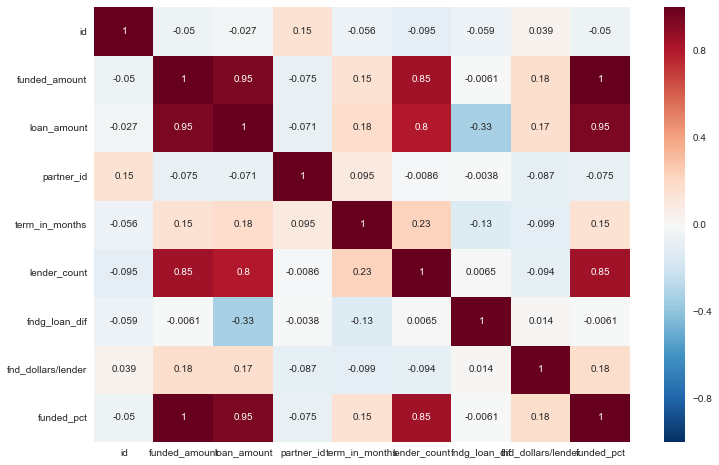

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(main.corr(), annot = True)
plt.show()